# **Keras Retinanet model for Pneumonia Detection**

Below model has been developed referring mainly to below kaggle notebook:
https://www.kaggle.com/chittalpatel/global-wheat-detection-keras-retinanet-eda/notebook

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image, ImageDraw
from ast import literal_eval
import matplotlib.pyplot as plt
import urllib
from tqdm.notebook import tqdm

### Installing Keras RetinaNet

In [2]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 13.47 MiB | 7.35 MiB/s, done.
Resolving deltas: 100% (4201/4201), done.


In [3]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=168009 sha256=c089dceccc03573978488e2767e2d0a90319715c15757aa8e3522ff9abe2e59b
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=d7330f3219cf116138de52c805b0798a86d8a86325ec7fb7338b68042fab066f
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [4]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/keras_retinanet
creating build/temp.linux-x86_64-3.7/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -

In [5]:
import tensorflow as tf
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

### Exploratory Data Analysis

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
root = '/content/drive/My Drive/Capstone/RetinanetPneuDet/'
#train_img = root+"JPEGImagesTrainAnno1"
#train_img = root+"JPEGImagesNew"
#test_img = root+"JPEGImagesTrainCh1"
train_csv = root+"train.csv"
#sample_submission = root+"sample_submission.csv"

In [8]:
train_img = root+"FinalJPEGTrainImages"

In [9]:
train = pd.read_csv(train_csv)
train.head(10)

patientId  ...                          bbox
0  00436515-870c-4b36-a041-de91049b9ab4  ...  [264.0, 152.0, 213.0, 379.0]
1  00436515-870c-4b36-a041-de91049b9ab4  ...  [562.0, 152.0, 256.0, 453.0]
2  00704310-78a8-4b38-8475-49f4573b2dbb  ...  [323.0, 577.0, 160.0, 104.0]
3  00704310-78a8-4b38-8475-49f4573b2dbb  ...  [695.0, 575.0, 162.0, 137.0]
4  00aecb01-a116-45a2-956c-08d2fa55433f  ...   [288.0, 322.0, 94.0, 135.0]
5  00aecb01-a116-45a2-956c-08d2fa55433f  ...  [547.0, 299.0, 119.0, 165.0]
6  00c0b293-48e7-4e16-ac76-9269ba535a62  ...  [306.0, 544.0, 168.0, 244.0]
7  00c0b293-48e7-4e16-ac76-9269ba535a62  ...  [650.0, 511.0, 206.0, 284.0]
8  00f08de1-517e-4652-a04f-d1dc9ee48593  ...  [181.0, 184.0, 206.0, 506.0]
9  00f08de1-517e-4652-a04f-d1dc9ee48593  ...  [571.0, 275.0, 230.0, 476.0]

[10 rows x 9 columns]

There are more than one bounding boxes for same image

In [10]:
print(f"Total Bboxes: {train.shape[0]}")

Total Bboxes: 6700


In [11]:
unique_images = train['patientId'].unique()
len(unique_images)

4200

In [12]:
train_unique = train.drop_duplicates(subset = "patientId",inplace=False)

In [13]:
train_unique

patientId  ...                          bbox
0     00436515-870c-4b36-a041-de91049b9ab4  ...  [264.0, 152.0, 213.0, 379.0]
2     00704310-78a8-4b38-8475-49f4573b2dbb  ...  [323.0, 577.0, 160.0, 104.0]
4     00aecb01-a116-45a2-956c-08d2fa55433f  ...   [288.0, 322.0, 94.0, 135.0]
6     00c0b293-48e7-4e16-ac76-9269ba535a62  ...  [306.0, 544.0, 168.0, 244.0]
8     00f08de1-517e-4652-a04f-d1dc9ee48593  ...  [181.0, 184.0, 206.0, 506.0]
...                                    ...  ...                           ...
6692  b8d1e054-382a-42df-b371-596ea8886162  ...  [290.0, 478.0, 178.0, 278.0]
6694  b8d5cabd-d5b5-4ac4-b1d1-f0f80be47619  ...  [320.0, 403.0, 118.0, 192.0]
6695  b8d6b40d-2a3d-475f-88d3-03560f645223  ...  [176.0, 126.0, 255.0, 460.0]
6697  b8d7b42e-8dc7-4330-a8f3-db52852f1714  ...  [175.0, 563.0, 229.0, 277.0]
6699  b8d825e5-fcd7-491e-a45a-9b04f5433092  ...  [687.0, 352.0, 200.0, 626.0]

[4200 rows x 9 columns]

In [14]:
train_dataset = train_unique.iloc[0:3400,:]
train_dataset

patientId  ...                          bbox
0     00436515-870c-4b36-a041-de91049b9ab4  ...  [264.0, 152.0, 213.0, 379.0]
2     00704310-78a8-4b38-8475-49f4573b2dbb  ...  [323.0, 577.0, 160.0, 104.0]
4     00aecb01-a116-45a2-956c-08d2fa55433f  ...   [288.0, 322.0, 94.0, 135.0]
6     00c0b293-48e7-4e16-ac76-9269ba535a62  ...  [306.0, 544.0, 168.0, 244.0]
8     00f08de1-517e-4652-a04f-d1dc9ee48593  ...  [181.0, 184.0, 206.0, 506.0]
...                                    ...  ...                           ...
5353  a6cbb3dd-75ab-4671-a6b0-9a51c04a81ec  ...  [234.0, 502.0, 229.0, 348.0]
5355  a6d7b6da-d474-4195-8270-08fdfd6e8a20  ...  [688.0, 278.0, 184.0, 233.0]
5356  a6d95e82-3d6c-4047-abf2-505f059cdf17  ...  [200.0, 310.0, 211.0, 436.0]
5357  a6e29ab5-cb08-4bae-b028-f97cf3bfd943  ...  [154.0, 160.0, 315.0, 597.0]
5359  a6e6e9be-4ced-4c05-ad59-a07061fe72d6  ...  [217.0, 467.0, 296.0, 331.0]

[3400 rows x 9 columns]

In [15]:
list_train_images = train_dataset['patientId']
list_train_images.to_frame()
print (list_train_images)

0       00436515-870c-4b36-a041-de91049b9ab4
2       00704310-78a8-4b38-8475-49f4573b2dbb
4       00aecb01-a116-45a2-956c-08d2fa55433f
6       00c0b293-48e7-4e16-ac76-9269ba535a62
8       00f08de1-517e-4652-a04f-d1dc9ee48593
                        ...                 
5353    a6cbb3dd-75ab-4671-a6b0-9a51c04a81ec
5355    a6d7b6da-d474-4195-8270-08fdfd6e8a20
5356    a6d95e82-3d6c-4047-abf2-505f059cdf17
5357    a6e29ab5-cb08-4bae-b028-f97cf3bfd943
5359    a6e6e9be-4ced-4c05-ad59-a07061fe72d6
Name: patientId, Length: 3400, dtype: object


In [ ]:
#list_train_images.to_csv(r'/content/drive/My Drive/Capstone/RetinanetPneuDet/ListTrainImages.csv')

In [16]:
import os
import shutil
import csv

In [ ]:
import os
import shutil
import csv

valid_files = set()  # empty set
with open('/content/drive/My Drive/Capstone/RetinanetPneuDet/ListTrainImages.csv', 'r') as f:
    for rowDict in csv.reader(f, delimiter=','):
       valid_files |= {rowDict[1]+".jpg"}  # add file name to set
       print(rowDict)  # if desired

dir_src = '/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesTrainAnno/'
dir_dst = '/content/drive/My Drive/Capstone/RetinanetPneuDet/FinalJPEGTrainImages/'
for file in os.listdir(dir_src):
    if file in valid_files:
        src_file = os.path.join(dir_src, file)
        dst_file = os.path.join(dir_dst, file)
        shutil.move(src_file, dst_file)

['', 'patientId']
['0', '00436515-870c-4b36-a041-de91049b9ab4']
['2', '00704310-78a8-4b38-8475-49f4573b2dbb']
['4', '00aecb01-a116-45a2-956c-08d2fa55433f']
['6', '00c0b293-48e7-4e16-ac76-9269ba535a62']
['8', '00f08de1-517e-4652-a04f-d1dc9ee48593']
['10', '0100515c-5204-4f31-98e0-f35e4b00004a']
['11', '010ccb9f-6d46-4380-af11-84f87397a1b8']
['13', '012a5620-d082-4bb8-9b3b-e72d8938000c']
['15', '0174c4bb-28f5-41e3-a13f-a396badc18bd']
['17', '019d950b-dd38-4cf3-a686-527a75728be6']
['19', '01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce']
['21', '01a7353d-25bb-4ff8-916b-f50dd541dccf']
['23', '01adfd2f-7bc7-4cef-ab68-a0992752b620']
['24', '01b9e362-4950-40f5-88fa-7557ac2a45bb']
['26', '01be392f-a46d-4aef-a57e-9cd1a80dd47e']
['28', '01cad8d0-45cd-4603-b099-94055d322310']
['30', '01cd2ba5-2baf-44b2-bf15-ee57e1ea4599']
['31', '01d4fa0f-97a0-4522-b0d8-134400db2a3e']
['33', '01dc817c-3cfa-49fe-8662-518edc30652a']
['34', '01f3abc2-33c7-4ea2-a599-dc49b76fcfae']
['36', '01fa0f5e-00c3-41cb-b5c7-10600c8633ae']


FileNotFoundError: ignored

In [ ]:
import os
import shutil
import csv

valid_files = set()  # empty set
with open('/content/drive/My Drive/Capstone/RetinanetPneuDet/ListTrainImages.csv', 'r') as f:
    for rowDict in csv.reader(f, delimiter=','):
       valid_files |= {rowDict[1]+".jpg"}  # add file name to set
       print(rowDict)  # if desired

dir_src = '/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesTrainAnno1/'
dir_dst = '/content/drive/My Drive/Capstone/RetinanetPneuDet/FinalJPEGTrainImages/'
for file in os.listdir(dir_src):
    if file in valid_files:
        src_file = os.path.join(dir_src, file)
        dst_file = os.path.join(dir_dst, file)
        shutil.copy2(src_file, dst_file)

['', 'patientId']
['0', '00436515-870c-4b36-a041-de91049b9ab4']
['2', '00704310-78a8-4b38-8475-49f4573b2dbb']
['4', '00aecb01-a116-45a2-956c-08d2fa55433f']
['6', '00c0b293-48e7-4e16-ac76-9269ba535a62']
['8', '00f08de1-517e-4652-a04f-d1dc9ee48593']
['10', '0100515c-5204-4f31-98e0-f35e4b00004a']
['11', '010ccb9f-6d46-4380-af11-84f87397a1b8']
['13', '012a5620-d082-4bb8-9b3b-e72d8938000c']
['15', '0174c4bb-28f5-41e3-a13f-a396badc18bd']
['17', '019d950b-dd38-4cf3-a686-527a75728be6']
['19', '01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce']
['21', '01a7353d-25bb-4ff8-916b-f50dd541dccf']
['23', '01adfd2f-7bc7-4cef-ab68-a0992752b620']
['24', '01b9e362-4950-40f5-88fa-7557ac2a45bb']
['26', '01be392f-a46d-4aef-a57e-9cd1a80dd47e']
['28', '01cad8d0-45cd-4603-b099-94055d322310']
['30', '01cd2ba5-2baf-44b2-bf15-ee57e1ea4599']
['31', '01d4fa0f-97a0-4522-b0d8-134400db2a3e']
['33', '01dc817c-3cfa-49fe-8662-518edc30652a']
['34', '01f3abc2-33c7-4ea2-a599-dc49b76fcfae']
['36', '01fa0f5e-00c3-41cb-b5c7-10600c8633ae']


In [ ]:
import os
import shutil
import csv

valid_files = set()  # empty set
with open('/content/drive/My Drive/Capstone/RetinanetPneuDet/ListTrainImages.csv', 'r') as f:
    for rowDict in csv.reader(f, delimiter=','):
       valid_files |= {rowDict[1]+".jpg"}  # add file name to set
       print(rowDict)  # if desired

dir_src = '/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesOld?/'
dir_dst = '/content/drive/My Drive/Capstone/RetinanetPneuDet/FinalJPEGTrainImages/'
for file in os.listdir(dir_src):
    if file in valid_files:
        src_file = os.path.join(dir_src, file)
        dst_file = os.path.join(dir_dst, file)
        shutil.copy2(src_file, dst_file)

['', 'patientId']
['0', '00436515-870c-4b36-a041-de91049b9ab4']
['2', '00704310-78a8-4b38-8475-49f4573b2dbb']
['4', '00aecb01-a116-45a2-956c-08d2fa55433f']
['6', '00c0b293-48e7-4e16-ac76-9269ba535a62']
['8', '00f08de1-517e-4652-a04f-d1dc9ee48593']
['10', '0100515c-5204-4f31-98e0-f35e4b00004a']
['11', '010ccb9f-6d46-4380-af11-84f87397a1b8']
['13', '012a5620-d082-4bb8-9b3b-e72d8938000c']
['15', '0174c4bb-28f5-41e3-a13f-a396badc18bd']
['17', '019d950b-dd38-4cf3-a686-527a75728be6']
['19', '01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce']
['21', '01a7353d-25bb-4ff8-916b-f50dd541dccf']
['23', '01adfd2f-7bc7-4cef-ab68-a0992752b620']
['24', '01b9e362-4950-40f5-88fa-7557ac2a45bb']
['26', '01be392f-a46d-4aef-a57e-9cd1a80dd47e']
['28', '01cad8d0-45cd-4603-b099-94055d322310']
['30', '01cd2ba5-2baf-44b2-bf15-ee57e1ea4599']
['31', '01d4fa0f-97a0-4522-b0d8-134400db2a3e']
['33', '01dc817c-3cfa-49fe-8662-518edc30652a']
['34', '01f3abc2-33c7-4ea2-a599-dc49b76fcfae']
['36', '01fa0f5e-00c3-41cb-b5c7-10600c8633ae']


In [17]:
test_dataset = train_unique.iloc[3400:4200,:]
test_dataset

patientId  ...                          bbox
5361  a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b  ...  [186.0, 178.0, 252.0, 282.0]
5362  a70544fd-cd5f-4650-9008-224672ccd7b6  ...  [127.0, 356.0, 281.0, 453.0]
5364  a70f69e6-aae3-459e-a3dc-175a2bcae6b9  ...  [219.0, 366.0, 229.0, 352.0]
5365  a7170988-66ea-4448-bfd7-d64b06d33753  ...  [672.0, 385.0, 229.0, 317.0]
5366  a73a46b2-fcef-41ad-a292-60df60ebba72  ...  [183.0, 267.0, 256.0, 438.0]
...                                    ...  ...                           ...
6692  b8d1e054-382a-42df-b371-596ea8886162  ...  [290.0, 478.0, 178.0, 278.0]
6694  b8d5cabd-d5b5-4ac4-b1d1-f0f80be47619  ...  [320.0, 403.0, 118.0, 192.0]
6695  b8d6b40d-2a3d-475f-88d3-03560f645223  ...  [176.0, 126.0, 255.0, 460.0]
6697  b8d7b42e-8dc7-4330-a8f3-db52852f1714  ...  [175.0, 563.0, 229.0, 277.0]
6699  b8d825e5-fcd7-491e-a45a-9b04f5433092  ...  [687.0, 352.0, 200.0, 626.0]

[800 rows x 9 columns]

In [18]:
list_val_images = test_dataset['patientId']
list_val_images.to_frame()
print (list_val_images)

5361    a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b
5362    a70544fd-cd5f-4650-9008-224672ccd7b6
5364    a70f69e6-aae3-459e-a3dc-175a2bcae6b9
5365    a7170988-66ea-4448-bfd7-d64b06d33753
5366    a73a46b2-fcef-41ad-a292-60df60ebba72
                        ...                 
6692    b8d1e054-382a-42df-b371-596ea8886162
6694    b8d5cabd-d5b5-4ac4-b1d1-f0f80be47619
6695    b8d6b40d-2a3d-475f-88d3-03560f645223
6697    b8d7b42e-8dc7-4330-a8f3-db52852f1714
6699    b8d825e5-fcd7-491e-a45a-9b04f5433092
Name: patientId, Length: 800, dtype: object


In [ ]:
#list_val_images.to_csv(r'/content/drive/My Drive/Capstone/RetinanetPneuDet/ListValImages.csv')

In [19]:
import os
import shutil
import csv

valid_files = set()  # empty set
with open('/content/drive/My Drive/Capstone/RetinanetPneuDet/ListValImages.csv', 'r') as f:
    for rowDict in csv.reader(f, delimiter=','):
       valid_files |= {rowDict[1]+".jpg"}  # add file name to set
       print(rowDict)  # if desired

dir_src = '/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesTrainAnno1/'
dir_dst = '/content/drive/My Drive/Capstone/RetinanetPneuDet/FinalJPEGValimages/'
for file in os.listdir(dir_src):
    if file in valid_files:
        src_file = os.path.join(dir_src, file)
        dst_file = os.path.join(dir_dst, file)
        shutil.copy2(src_file, dst_file)

['', 'patientId']
['5361', 'a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b']
['5362', 'a70544fd-cd5f-4650-9008-224672ccd7b6']
['5364', 'a70f69e6-aae3-459e-a3dc-175a2bcae6b9']
['5365', 'a7170988-66ea-4448-bfd7-d64b06d33753']
['5366', 'a73a46b2-fcef-41ad-a292-60df60ebba72']
['5368', 'a74060c8-870a-47e1-9bc9-c1226caf9a87']
['5369', 'a746732a-d4ad-4de9-8dae-d4542e64db08']
['5371', 'a754f888-8407-4228-be35-17a0140ef6cf']
['5372', 'a770c776-65f4-4630-8b51-0a458a96780f']
['5373', 'a7714d9a-c359-4edd-94a4-c6943c437021']
['5374', 'a771930c-cb2d-4fcd-8ee4-8ce2acdd1115']
['5375', 'a77b32f6-1999-4cc6-8a0d-1ef7e53850f0']
['5377', 'a797f1b9-aa61-4ee3-91f2-e8a823d42b1a']
['5379', 'a7a08920-e6ca-4638-a59b-ac10d5e58c8c']
['5380', 'a7a30231-a1b4-4305-ad66-6a707a27a1a4']
['5382', 'a7a4389b-29dd-409d-82b7-edf2633032a8']
['5384', 'a7a45cd9-785e-402c-a66c-4762b71ec4bb']
['5386', 'a7a95de8-1075-49df-a0ed-edc1baca084d']
['5387', 'a7adf94f-aac5-4d65-a860-1b54596bcb51']
['5388', 'a7b7222f-91db-467e-afb7-68f44f06c6a2']
['

KeyboardInterrupt: ignored

In [ ]:
import os
import shutil
import csv

valid_files = set()  # empty set
with open('/content/drive/My Drive/Capstone/RetinanetPneuDet/ListValImages.csv', 'r') as f:
    for rowDict in csv.reader(f, delimiter=','):
       valid_files |= {rowDict[1]+".jpg"}  # add file name to set
       print(rowDict)  # if desired

dir_src = '/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesOld?/'
dir_dst = '/content/drive/My Drive/Capstone/RetinanetPneuDet/FinalJPEGValimages/'
for file in os.listdir(dir_src):
    if file in valid_files:
        src_file = os.path.join(dir_src, file)
        dst_file = os.path.join(dir_dst, file)
        shutil.copy2(src_file, dst_file)

['', 'patientId']
['5361', 'a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b']
['5362', 'a70544fd-cd5f-4650-9008-224672ccd7b6']
['5364', 'a70f69e6-aae3-459e-a3dc-175a2bcae6b9']
['5365', 'a7170988-66ea-4448-bfd7-d64b06d33753']
['5366', 'a73a46b2-fcef-41ad-a292-60df60ebba72']
['5368', 'a74060c8-870a-47e1-9bc9-c1226caf9a87']
['5369', 'a746732a-d4ad-4de9-8dae-d4542e64db08']
['5371', 'a754f888-8407-4228-be35-17a0140ef6cf']
['5372', 'a770c776-65f4-4630-8b51-0a458a96780f']
['5373', 'a7714d9a-c359-4edd-94a4-c6943c437021']
['5374', 'a771930c-cb2d-4fcd-8ee4-8ce2acdd1115']
['5375', 'a77b32f6-1999-4cc6-8a0d-1ef7e53850f0']
['5377', 'a797f1b9-aa61-4ee3-91f2-e8a823d42b1a']
['5379', 'a7a08920-e6ca-4638-a59b-ac10d5e58c8c']
['5380', 'a7a30231-a1b4-4305-ad66-6a707a27a1a4']
['5382', 'a7a4389b-29dd-409d-82b7-edf2633032a8']
['5384', 'a7a45cd9-785e-402c-a66c-4762b71ec4bb']
['5386', 'a7a95de8-1075-49df-a0ed-edc1baca084d']
['5387', 'a7adf94f-aac5-4d65-a860-1b54596bcb51']
['5388', 'a7b7222f-91db-467e-afb7-68f44f06c6a2']
['

In [20]:
unique_images2 = test_dataset['patientId'].unique()
len(unique_images2)

800

In [21]:
test_img = root+"FinalJPEGValimages"
num_total1 = len(os.listdir(test_img))
num_annotated1 = len(unique_images2)
print(f"There are {num_annotated1} annotated val images and {num_total1 - num_annotated1} images without annotations.")

There are 800 annotated val images and 0 images without annotations.


In [ ]:
#bboxs=[ bbox[1:-1].split(', ') for bbox in test_dataset['bbox']]
#bboxs=[ f"{int(float(bbox[0]))},{int(float(bbox[1]))},{int(float(bbox[0]))+int(float(bbox[2]))},{int(float(bbox[1])) + int(float(bbox[3]))}" for bbox in bboxs]
#test_dataset['bbox_']=bboxs
#test_dataset.head()

In [22]:
bboxs=[ bbox[1:-1].split(', ') for bbox in test_dataset['bbox']]
bboxs=[ f"{int(float(bbox[0]))},{int(float(bbox[1]))},{int(float(bbox[0]))+int(float(bbox[2]))},{int(float(bbox[1])) + int(float(bbox[3]))},LungOpacity" for bbox in bboxs]
test_dataset['bbox_']=bboxs
test_dataset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


patientId  ...                        bbox_
5361  a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b  ...  186,178,438,460,LungOpacity
5362  a70544fd-cd5f-4650-9008-224672ccd7b6  ...  127,356,408,809,LungOpacity
5364  a70f69e6-aae3-459e-a3dc-175a2bcae6b9  ...  219,366,448,718,LungOpacity
5365  a7170988-66ea-4448-bfd7-d64b06d33753  ...  672,385,901,702,LungOpacity
5366  a73a46b2-fcef-41ad-a292-60df60ebba72  ...  183,267,439,705,LungOpacity

[5 rows x 10 columns]

In [23]:
annotation_val=test_dataset[['patientId','bbox_']]
annotation_val.head()

patientId                        bbox_
5361  a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b  186,178,438,460,LungOpacity
5362  a70544fd-cd5f-4650-9008-224672ccd7b6  127,356,408,809,LungOpacity
5364  a70f69e6-aae3-459e-a3dc-175a2bcae6b9  219,366,448,718,LungOpacity
5365  a7170988-66ea-4448-bfd7-d64b06d33753  672,385,901,702,LungOpacity
5366  a73a46b2-fcef-41ad-a292-60df60ebba72  183,267,439,705,LungOpacity

In [24]:
with open("annotations_val.csv","w") as file:
    for idx in range(len(annotation_val)):
        file.write(test_img+"/"+annotation_val.iloc[idx,0]+".jpg"+","+annotation_val.iloc[idx,1]+"\n")

In [25]:
unique_images1 = train_dataset['patientId'].unique()
len(unique_images1)

3400

In [26]:
num_total = len(os.listdir(train_img))
num_annotated = len(unique_images1)
print(f"There are {num_annotated} annotated images and {num_total - num_annotated} images without annotations.")

There are 3400 annotated images and 0 images without annotations.


Let us look at how many bounding boxes we have per image

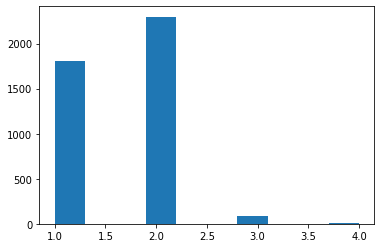

In [27]:
plt.hist(train['patientId'].value_counts(), bins=10)
plt.show()

A large proportion (more than 50%) of xrays have 2 bounding boxes and the rest have only 1. A very small number of xrays have 3 bounding boxes.

### Resizing the images

In [28]:
#path = '/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesNew' # Source Folder
dstpath = '/content/drive/My Drive/Capstone/RetinanetPneuDet/FinalJPEGTrainImages' # Destination Folder

In [ ]:
#images already resized, hence need not run the code again

#import cv2
#import os,glob
#from os import listdir,makedirs

#from os.path import isfile,join
#path = '/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesNew' # Source Folder
#dstpath = '/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesTrainCh1' # Destination Folder
#try:
#    makedirs(dstpath)
#except:
#    print ("Directory already exist, images will be written in same folder")
# Folder won't used
#files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
#for image in files:
#    try:
#       img = cv2.imread(os.path.join(path,image))
#        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#        dstPath = join(dstpath,image)
#        cv2.imwrite(dstPath,gray)
#    except:
#        print ("{} is not converted".format(image))
#for fil in glob.glob("*.jpg"):
#    try:
#        image = cv2.imread(fil) 
#        gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY) # convert to greyscale
#        cv2.imwrite(os.path.join(dstpath,fil),gray_image)
#    except:
#        print('{} is not converted')

In [29]:
y = np.expand_dims(dstpath+"3036fb15-305b-4e9b-93ab-4e555a0fd323.jpg", axis=-1)
y.shape

(1,)

In [ ]:
#check number of files created. need not run again.
#import os

#path, dirs, files = next(os.walk("/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesTrainCh1"))
#file_count = len(files)
#print (file_count)

### Visualizing the images

In [30]:
def get_bbox_area(bbox):
    bbox = literal_eval(bbox)
    return bbox[2] * bbox[3]

In [31]:
def show_images(images, num = 5):
    
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image_path = os.path.join(train_img, image_id + ".jpg")
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes = [literal_eval(box) for box in train_dataset[train_dataset['patientId'] == image_id]['bbox']]

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]], width=3)

        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.show()

In [32]:
print (unique_images1)

['00436515-870c-4b36-a041-de91049b9ab4'
 '00704310-78a8-4b38-8475-49f4573b2dbb'
 '00aecb01-a116-45a2-956c-08d2fa55433f' ...
 'a6d95e82-3d6c-4047-abf2-505f059cdf17'
 'a6e29ab5-cb08-4bae-b028-f97cf3bfd943'
 'a6e6e9be-4ced-4c05-ad59-a07061fe72d6']


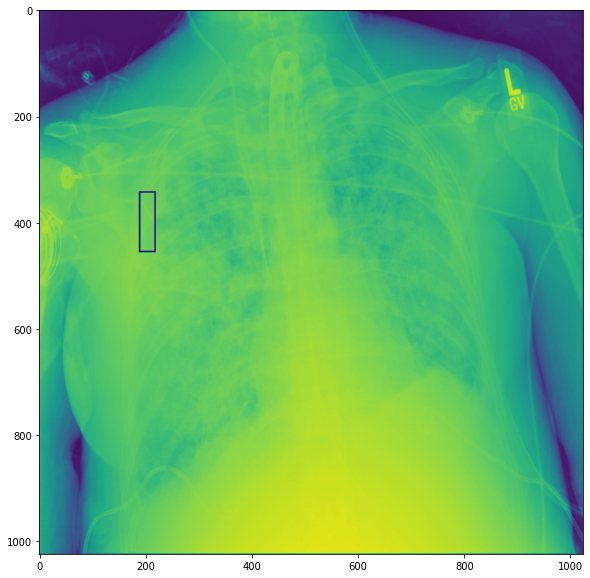

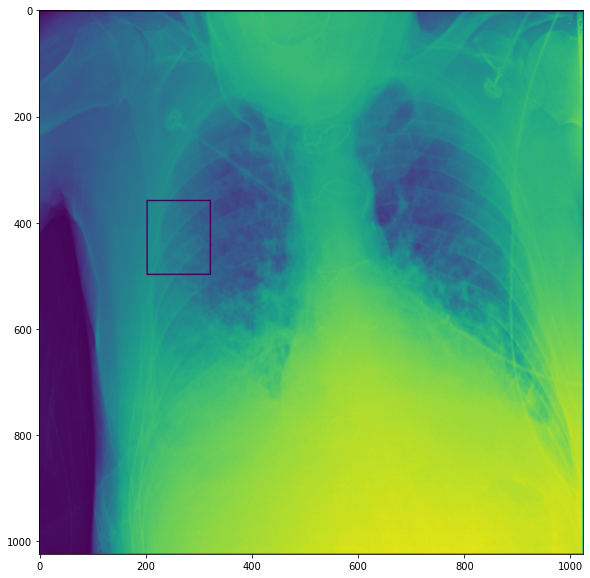

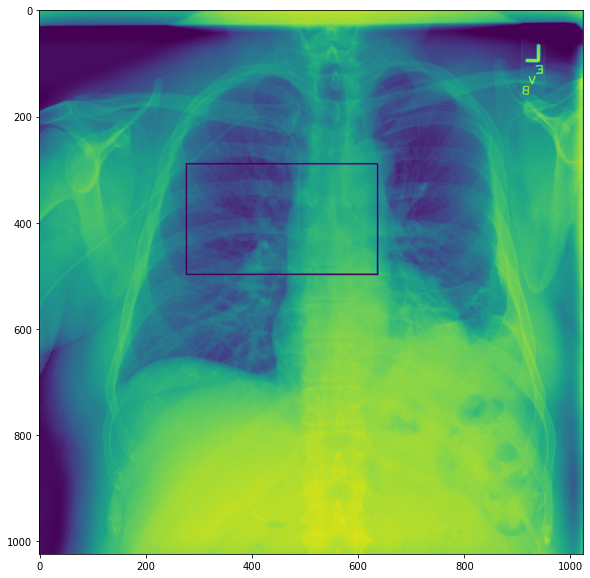

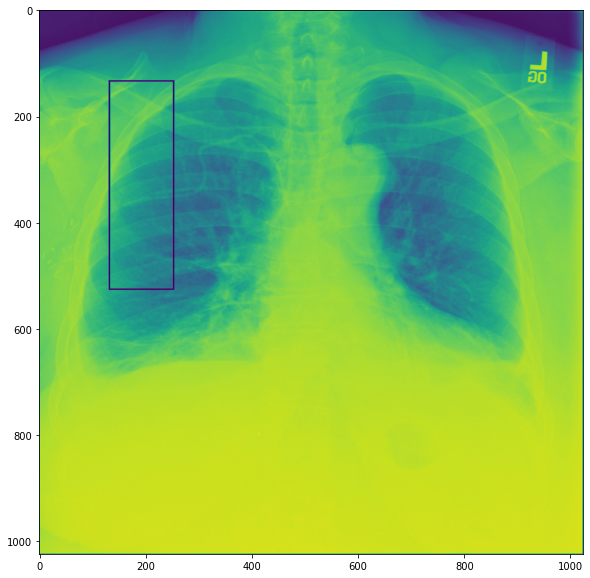

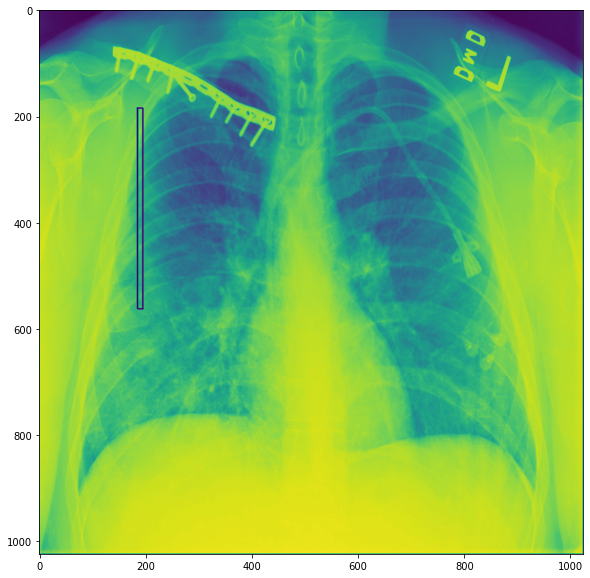

In [33]:
show_images(unique_images1)

### Pre-processing of data for Keras-RetinaNet

In [ ]:
#bboxs=[ bbox[1:-1].split(', ') for bbox in train_dataset['bbox']]
#bboxs=[ f"{int(float(bbox[0]))},{int(float(bbox[1]))},{int(float(bbox[0]))+int(float(bbox[2]))},{int(float(bbox[1])) + int(float(bbox[3]))}" for bbox in bboxs]
#train_dataset['bbox_']=bboxs
#train_dataset.head()

In [34]:
bboxs=[ bbox[1:-1].split(', ') for bbox in train_dataset['bbox']]
bboxs=[ f"{int(float(bbox[0]))},{int(float(bbox[1]))},{int(float(bbox[0]))+int(float(bbox[2]))},{int(float(bbox[1])) + int(float(bbox[3]))},LungOpacity" for bbox in bboxs]
train_dataset['bbox_']=bboxs
train_dataset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


patientId  ...                        bbox_
0  00436515-870c-4b36-a041-de91049b9ab4  ...  264,152,477,531,LungOpacity
2  00704310-78a8-4b38-8475-49f4573b2dbb  ...  323,577,483,681,LungOpacity
4  00aecb01-a116-45a2-956c-08d2fa55433f  ...  288,322,382,457,LungOpacity
6  00c0b293-48e7-4e16-ac76-9269ba535a62  ...  306,544,474,788,LungOpacity
8  00f08de1-517e-4652-a04f-d1dc9ee48593  ...  181,184,387,690,LungOpacity

[5 rows x 10 columns]

In [35]:
annotation_df=train_dataset[['patientId','bbox_']]
annotation_df.head()

patientId                        bbox_
0  00436515-870c-4b36-a041-de91049b9ab4  264,152,477,531,LungOpacity
2  00704310-78a8-4b38-8475-49f4573b2dbb  323,577,483,681,LungOpacity
4  00aecb01-a116-45a2-956c-08d2fa55433f  288,322,382,457,LungOpacity
6  00c0b293-48e7-4e16-ac76-9269ba535a62  306,544,474,788,LungOpacity
8  00f08de1-517e-4652-a04f-d1dc9ee48593  181,184,387,690,LungOpacity

In [36]:
annotation_df=annotation_df.sample(frac=1).reset_index(drop=True)
annotation_df.head()

patientId                        bbox_
0  01cad8d0-45cd-4603-b099-94055d322310  218,667,476,991,LungOpacity
1  58d2ffd9-f5a7-4215-9ca8-3b41536a989a  590,313,761,644,LungOpacity
2  97a91432-e516-425b-adf2-260b743f588c  489,370,765,656,LungOpacity
3  7a0105da-41e6-4500-8626-fb6e8f0dac5a  197,291,486,745,LungOpacity
4  3a711453-b25c-4239-9c8b-080070a8afcc  622,488,857,711,LungOpacity

### Preparing files for training

Annotation file should contain all the path of all images and their corresponding bounding boxes

In [37]:
with open("annotations.csv","w") as file:
    for idx in range(len(annotation_df)):
        file.write(train_img+"/"+annotation_df.iloc[idx,0]+".jpg"+","+annotation_df.iloc[idx,1]+"\n")

Class file should contain the number of classes. In our case, it is just 1 class - LungOpacity

In [38]:
with open("classes.csv","w") as file:
    file.write("LungOpacity,0")

## Downloading pre trained model

In [39]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


#### Model Parameters

#### Training the model

In [42]:
!keras_retinanet/bin/train.py \
  --random-transform \
  --workers 0 \
  --weights {PRETRAINED_MODEL} \
  --batch-size 8 \
  --steps 100 \
  --image-min-side 512 \
  --image-max-side 512 \
  --epochs 30 \
  csv annotations.csv classes.csv
  

  #--image-min-side 512\
  #--image-max-side 512\
  #changed nms_threshold in filter_detections.py from 0.5 to 0.2
  #changed score_threshold in filter_detection.py from 0.05 to .35
  #changed max_detections to 2
  #changed freeze_backbone from false to true in train.py

2021-03-10 19:22:19.110754: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Creating model, this may take a second...
2021-03-10 19:22:25.424350: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-10 19:22:25.425214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-10 19:22:25.451892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-10 19:22:25.452874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-03-10 19:22:25.452928: I tensorfl

In [ ]:
#!keras_retinanet/bin/train.py --random-transform --weights {PRETRAINED_MODEL} --batch-size {BATCH_SIZE} --steps {STEPS} --epochs {EPOCHS} --no-resize csv annotations.csv classes.csv

### Loading the trained model

In [43]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_11.h5  resnet50_csv_22.h5
resnet50_csv_01.h5    resnet50_csv_12.h5  resnet50_csv_23.h5
resnet50_csv_02.h5    resnet50_csv_13.h5  resnet50_csv_24.h5
resnet50_csv_03.h5    resnet50_csv_14.h5  resnet50_csv_25.h5
resnet50_csv_04.h5    resnet50_csv_15.h5  resnet50_csv_26.h5
resnet50_csv_05.h5    resnet50_csv_16.h5  resnet50_csv_27.h5
resnet50_csv_06.h5    resnet50_csv_17.h5  resnet50_csv_28.h5
resnet50_csv_07.h5    resnet50_csv_18.h5  resnet50_csv_29.h5
resnet50_csv_08.h5    resnet50_csv_19.h5  resnet50_csv_30.h5
resnet50_csv_09.h5    resnet50_csv_20.h5
resnet50_csv_10.h5    resnet50_csv_21.h5


In [44]:
#model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])

model = models.load_model('snapshots/resnet50_csv_30.h5', backbone_name='resnet50')
model = models.convert_model(model)

#Converting to inference model using the installed script:
#!keras_retinanet/bin/convert_model.py 'snapshots/resnet50_csv_03.h5' root+"snapshots/Inference/"

# load label to names mapping for visualization purposes
labels_to_names = pd.read_csv('classes.csv',header=None).T.loc[0].to_dict()

In [46]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

Saving 2408fba1-6704-44c7-b598-4e62504df533.jpg to 2408fba1-6704-44c7-b598-4e62504df533.jpg
Running inference on: 2408fba1-6704-44c7-b598-4e62504df533.jpg
processing time:  10.227339267730713


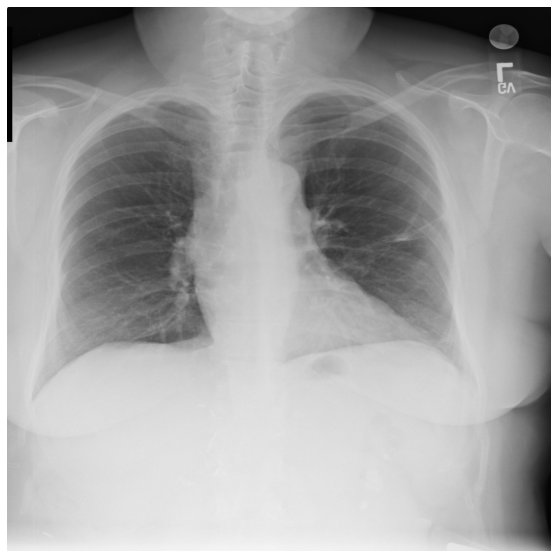

In [48]:
THRES_SCORE = .4
from google.colab import files
import time
uploaded = files.upload()
img_infer = list(uploaded)[0]
!
print('Running inference on: ' + img_infer)
img_inference(img_infer)

### Predictions

In [49]:
li=os.listdir(test_img)
l5=li[:5]
l5

['b05b4898-2003-4a43-a5bd-8de50200db4a.jpg',
 'b1a36998-390d-45e5-bd85-21c2c33690f3.jpg',
 'b1d07564-9432-4844-b8f7-0b968e3b9683.jpg',
 'b1f2db42-68ac-4c11-a4f4-3f6b8b6be999.jpg',
 'b24f4b3e-6e1b-4824-af10-270ec5093de3.jpg']

In [50]:
def predict(image):
    image = preprocess_image(image.copy())
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    return boxes, scores, labels

In [51]:
THRES_SCORE = 0.3

def draw_detections(image, boxes, scores, labels):
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < THRES_SCORE:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{:.3f}".format(score)
        draw_caption(image, b, caption)

In [53]:
def show_detected_objects(image_name):
    img_path = test_img+'/'+image_name
  
    image = read_image_bgr(img_path)

    boxes, scores, labels = predict(image)
    print(boxes[0,0].shape)
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    draw_detections(draw, boxes, scores, labels)
    plt.figure(figsize=(15,10))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

(4,)


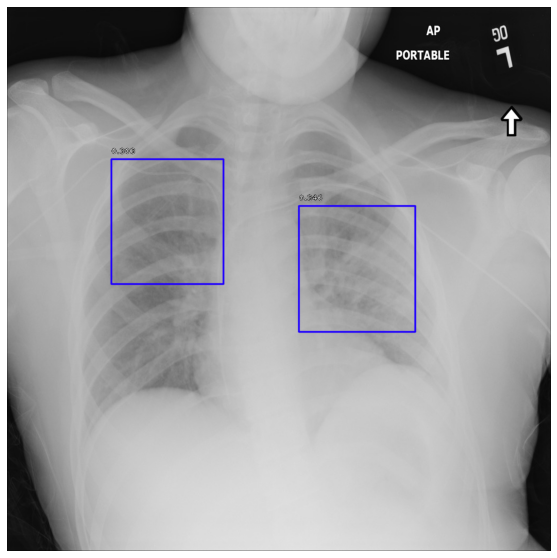

(4,)


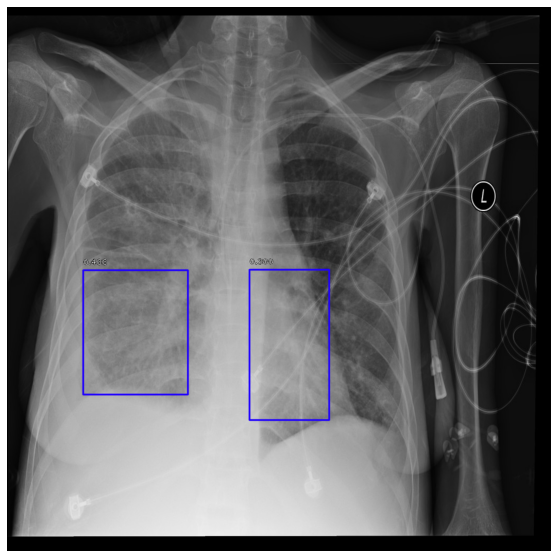

(4,)


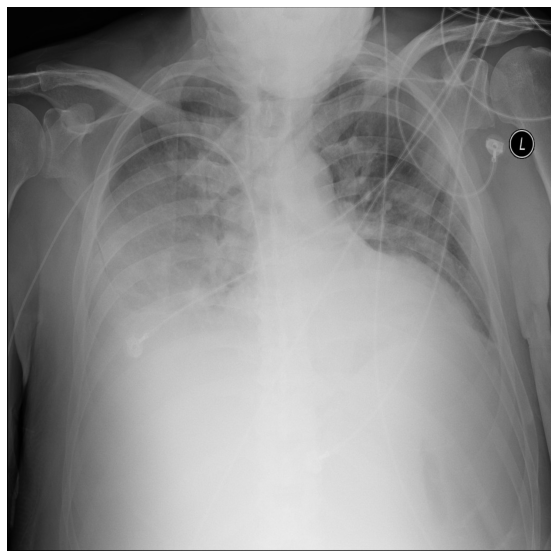

(4,)


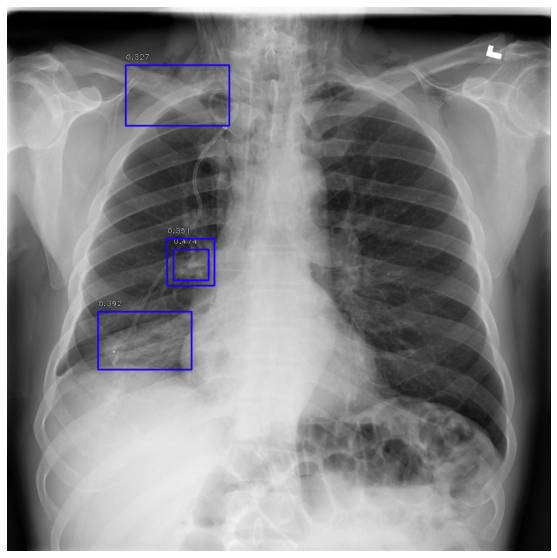

(4,)


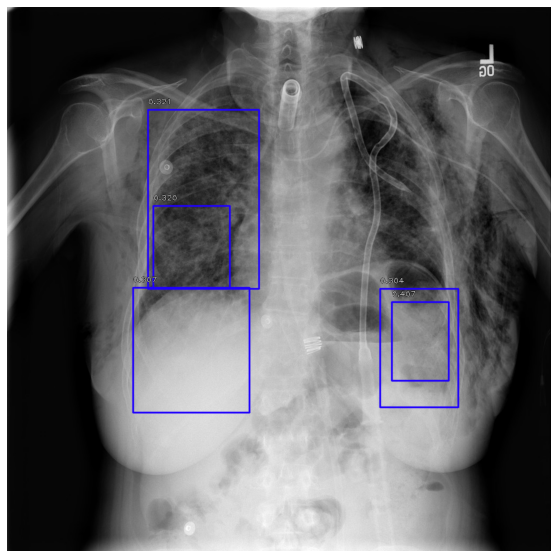

In [54]:
for img in l5:
    show_detected_objects(img)

In [ ]:
#!keras_retinanet/bin/evaluate.py csv annotations_test.csv classes.csv ./snapshots/resnet50_csv_03.h5

### Model validation

In [55]:
df_valid= pd.read_csv('annotations_val.csv', header=None)
df_valid.head()

0    1  ...    4            5
0  /content/drive/My Drive/Capstone/RetinanetPneu...  186  ...  460  LungOpacity
1  /content/drive/My Drive/Capstone/RetinanetPneu...  127  ...  809  LungOpacity
2  /content/drive/My Drive/Capstone/RetinanetPneu...  219  ...  718  LungOpacity
3  /content/drive/My Drive/Capstone/RetinanetPneu...  672  ...  702  LungOpacity
4  /content/drive/My Drive/Capstone/RetinanetPneu...  183  ...  705  LungOpacity

[5 rows x 6 columns]

In [56]:
n_classes= pd.read_csv('classes.csv', header=None)

classes= {}
classes_r= {}
for name, roll in zip(n_classes[0], n_classes[1]):
    classes[name]= roll
    classes_r[roll]=name

In [57]:
uniq= df_valid[0].unique().shape[0]
classes

{'LungOpacity': 0}

In [58]:
def predict(path, th=0.4, draw=True, show_time=True):
    
    # load image
    image = read_image_bgr(path)
    # copy to draw on
    image2 = image.copy()
    #image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    if show_time:
        print("processing time: ", time.time() - start)
    # correct for image scale
    boxes /= scale
    
    if draw:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted 
            if score < th:
                break
            color = label_color(label)
            b = box.astype(int)
            draw_box(image2, box, color=color)
            draw_caption(image2, box, classes_r[label])
        return image2
    else:
        return boxes[0], scores[0], labels[0]

In [59]:
def grd_vs_pred(i, th= 0.4):
    path= df_valid[0].unique()[i]
    grd_img= read_image_bgr(path)

    for r, row in df_valid[df_valid[0]==df_valid[0][i]].iterrows():
        color= label_color(classes[row[5]])
        grd_img= cv2.rectangle(np.array(grd_img), (row[1], row[2]), (row[3], row[4]), color, 2)
        draw_caption(grd_img, row[1:5].values, row[5])
    pred_img= predict(path, th=th)
    
    return grd_img, pred_img

In [60]:
import time

processing time:  0.30371952056884766
processing time:  0.2607128620147705
processing time:  0.24286389350891113
processing time:  0.22653889656066895


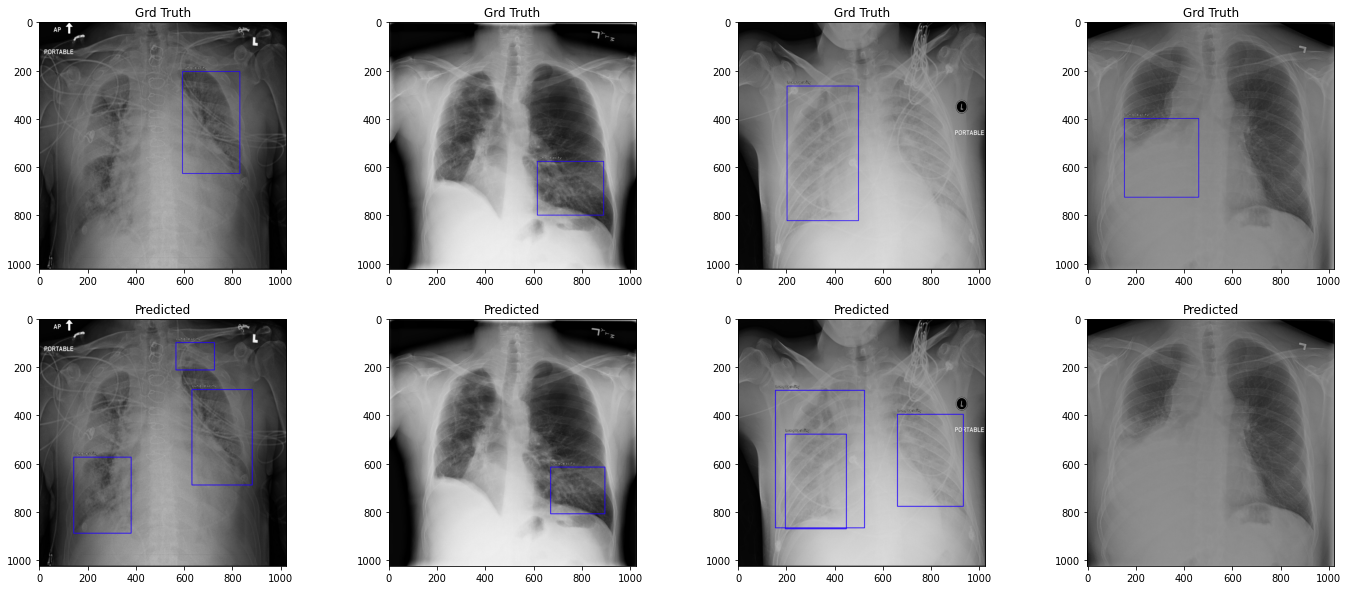

In [65]:
f, ax= plt.subplots(2, 4, figsize=(24, 10))

for i in range(4):
    np.random.seed(i*90)
    grd, pred= grd_vs_pred(np.random.randint(uniq), th= 0.3)
    ax[0][i%4].imshow(grd); ax[1][i%4].imshow(pred)
    ax[0][i%4].set_title('Grd Truth')
    ax[1][i%4].set_title('Predicted')
plt.show()